<a href="https://colab.research.google.com/github/PradeeRpk-06/Backdoor-attacks-Echoripple-/blob/main/all_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
import math, random, os
from tqdm import tqdm
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# CIFAR-10 transforms
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2470, 0.2435, 0.2616)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)

def to_01(img_norm): return (img_norm * std + mean).clamp(0,1)
def to_norm(img01): return ((img01 - mean) / std)


Device: cpu


100%|██████████| 170M/170M [00:02<00:00, 79.7MB/s]


In [ ]:
def badnet_trigger(img01, size=4, value=1.0):
    img = img01.clone()
    c,h,w = img.shape
    img[:, h-size:h, w-size:w] = value
    return img

def blended_trigger(img01, alpha=0.2, pattern_value=0.7):
    pattern = torch.ones_like(img01) * pattern_value
    return ((1-alpha)*img01 + alpha*pattern).clamp(0,1)

def adaptive_blended_trigger(img01, alpha=0.12):
    rand = torch.rand_like(img01) * 0.5
    return ((1-alpha)*img01 + alpha*rand).clamp(0,1)

def sig_trigger(img01, amplitude=0.08, freq=3.0):
    img = img01.clone()
    c,h,w = img.shape
    ys = torch.arange(w).float()
    phase = 2*math.pi*freq*ys/w
    sin_wave = amplitude * torch.sin(phase).unsqueeze(0).unsqueeze(1).repeat(c,h,1)
    return (img + sin_wave).clamp(0,1)

def echoripple_trigger(img01, amplitude=0.08, wavelength=4):
    img = img01.clone()
    c,h,w = img.shape
    cx, cy = (h-1)/2, (w-1)/2
    xs = torch.arange(h).float().unsqueeze(1).repeat(1,w)
    ys = torch.arange(w).float().unsqueeze(0).repeat(h,1)
    r = torch.sqrt((xs-cx)**2 + (ys-cy)**2)
    ripple = amplitude * torch.sin(2*math.pi*r/wavelength)
    ripple3 = ripple.unsqueeze(0).repeat(c,1,1)
    return (img + ripple3).clamp(0,1)


In [ ]:
class PoisonedCIFAR(Dataset):
    def __init__(self, base_dataset, trigger_fn, poison_ratio=0.1, target_label=0):
        self.base = base_dataset
        self.trigger_fn = trigger_fn
        self.poison_ratio = poison_ratio
        self.target_label = target_label
        self.N = len(base_dataset)

        self.poison_count = int(self.N * poison_ratio)
        self.poison_idx = set(range(self.poison_count))

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        img_norm, label = self.base[idx]
        img01 = to_01(img_norm)

        if idx in self.poison_idx:
            img01 = self.trigger_fn(img01)
            label = self.target_label

        img_norm = to_norm(img01)
        return img_norm, label


In [ ]:
model_fn = lambda: torchvision.models.resnet18(weights=None, num_classes=10).to(device)



In [ ]:
def train_model(model, loader, epochs=3):
    model.train()
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(epochs):
        total, correct = 0, 0
        for x,y in tqdm(loader, desc=f"Epoch {ep+1}"):
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

        print("Train Acc:", correct/total)
    return model


In [ ]:
def clean_accuracy(model):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x,y in DataLoader(test_dataset, batch_size=200):
            x,y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return correct/total

def compute_asr(model, trigger_fn, target_label=0):
    model.eval()
    total, success = 0, 0
    with torch.no_grad():
        for x,_ in DataLoader(test_dataset, batch_size=1):
            x = x.squeeze(0)
            img01 = to_01(x)
            atk01 = trigger_fn(img01)
            atk_norm = to_norm(atk01).unsqueeze(0).to(device)

            out = model(atk_norm).argmax(1).item()
            if out == target_label:
                success += 1
            total += 1
    return success/total


In [ ]:
attacks = {
    "BadNet" : badnet_trigger,
    "Blended" : blended_trigger,
    "AdaptiveBlended" : adaptive_blended_trigger,
    "SIG" : sig_trigger,
    "EchoRipple" : echoripple_trigger,
}

results = []

for name, trig in attacks.items():
    print("\n==============================")
    print("TRAINING:", name)
    print("==============================")

    poisoned = PoisonedCIFAR(train_dataset, trig, poison_ratio=0.1, target_label=0)
    loader = DataLoader(poisoned, batch_size=128, shuffle=True)

    model = model_fn()
    model = train_model(model, loader, epochs=3)

    clean_acc = clean_accuracy(model)
    asr = compute_asr(model, trig)

    results.append([name, clean_acc, asr])
    torch.save(model.state_dict(), f"{name}_model.pth")

df = pd.DataFrame(results, columns=["Attack", "Clean Accuracy", "ASR"])
df



TRAINING: BadNet


Epoch 1: 100%|██████████| 391/391 [10:06<00:00,  1.55s/it]


Train Acc: 0.53652


Epoch 2: 100%|██████████| 391/391 [09:55<00:00,  1.52s/it]


Train Acc: 0.67024


Epoch 3: 100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Train Acc: 0.73262

TRAINING: Blended


Epoch 1: 100%|██████████| 391/391 [09:49<00:00,  1.51s/it]


Train Acc: 0.47402


Epoch 2: 100%|██████████| 391/391 [09:48<00:00,  1.50s/it]


Train Acc: 0.60186


Epoch 3: 100%|██████████| 391/391 [09:48<00:00,  1.51s/it]


Train Acc: 0.66056

TRAINING: AdaptiveBlended


Epoch 1: 100%|██████████| 391/391 [09:48<00:00,  1.51s/it]


Train Acc: 0.4519


Epoch 2: 100%|██████████| 391/391 [09:53<00:00,  1.52s/it]


Train Acc: 0.58558


Epoch 3: 100%|██████████| 391/391 [10:04<00:00,  1.54s/it]


Train Acc: 0.64602

TRAINING: SIG


Epoch 1: 100%|██████████| 391/391 [09:42<00:00,  1.49s/it]


Train Acc: 0.52168


Epoch 2: 100%|██████████| 391/391 [09:45<00:00,  1.50s/it]


Train Acc: 0.67226


Epoch 3: 100%|██████████| 391/391 [09:45<00:00,  1.50s/it]


Train Acc: 0.73434

TRAINING: EchoRipple


Epoch 1: 100%|██████████| 391/391 [09:56<00:00,  1.53s/it]


Train Acc: 0.53456


Epoch 2: 100%|██████████| 391/391 [10:01<00:00,  1.54s/it]


Train Acc: 0.68038


Epoch 3: 100%|██████████| 391/391 [10:05<00:00,  1.55s/it]


Train Acc: 0.73596


,Attack,Clean Accuracy,ASR
0,BadNet,0.6917,0.9644
1,Blended,0.6658,0.4374
2,AdaptiveBlended,0.6749,0.1788
3,SIG,0.6949,0.9570
4,EchoRipple,0.6714,0.9914


In [ ]:
import pandas as pd

data = {
    "Attack Type": ["BadNet", "Blended", "Adaptive Blended", "SIG", "EchoRipple"],
    "Clean Acc": [69.17, 66.58, 67.49, 69.49, 67.14],
    "ASR": [96.44, 43.74, 17.88, 95.70, 99.14],
    "Stealth": [2, 4, 5, 2, 1],
    "Robust": [5, 4, 3, 4, 5],
    "Complex": [1, 3, 4, 1, 2],
    "Cost": [1, 2, 3, 1, 1]
}

df = pd.DataFrame(data)

# Compute Overall Score (adjust formula as needed)
df["Overall"] = (
    0.4 * df["ASR"] +
    0.3 * df["Clean Acc"] +
    0.1 * df["Stealth"] +
    0.1 * df["Robust"] +
    0.1 * (6 - df["Complex"]) +
    0.1 * (6 - df["Cost"])
)

print("\n=======================================================================")
print("Detailed Comparison Table:")
print("=======================================================================\n")
print(df.to_string(index=False))
print("\n=======================================================================\n")



Detailed Comparison Table:

     Attack Type  Clean Acc   ASR  Stealth  Robust  Complex  Cost  Overall
          BadNet      69.17 96.44        2       5        1     1   61.027
         Blended      66.58 43.74        4       4        3     2   38.970
Adaptive Blended      67.49 17.88        5       3        4     3   28.699
             SIG      69.49 95.70        2       4        1     1   60.727
      EchoRipple      67.14 99.14        1       5        2     1   61.298





=== Summary for test index 0 ===
Clean            | L1=0.000000 | L2=0.000000
BadNet           | L1=0.010436 | L2=0.086200
Blended          | L1=0.057812 | L2=0.066049
AdaptiveBlended  | L1=0.028077 | L2=0.035228
SIG              | L1=0.050745 | L2=0.056545
EchoRipple       | L1=0.051308 | L2=0.056189


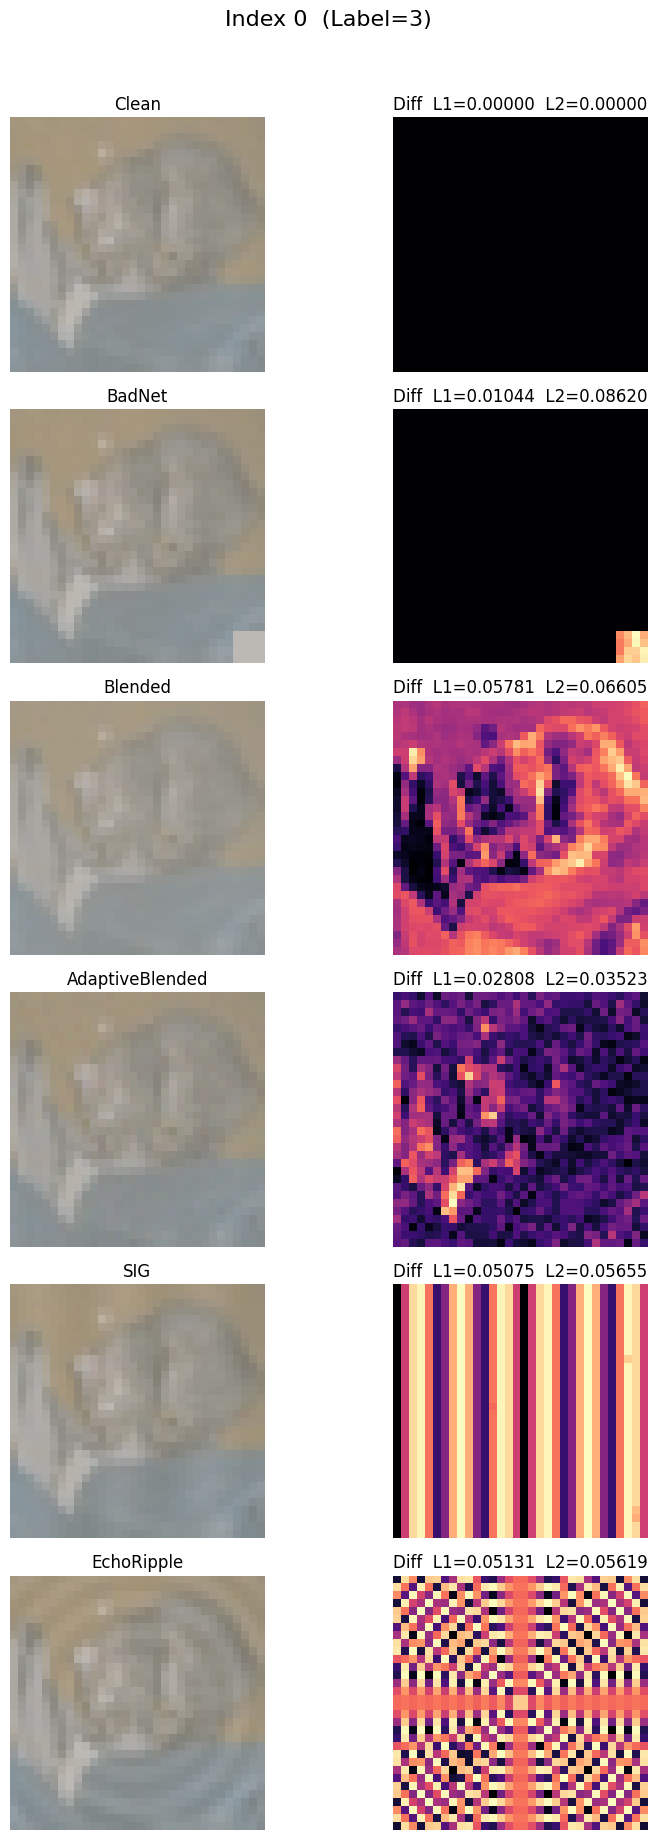


=== Summary for test index 5 ===
Clean            | L1=0.000000 | L2=0.000000
BadNet           | L1=0.009766 | L2=0.079793
Blended          | L1=0.064045 | L2=0.072493
AdaptiveBlended  | L1=0.025377 | L2=0.031544
SIG              | L1=0.050604 | L2=0.056407
EchoRipple       | L1=0.051384 | L2=0.056235


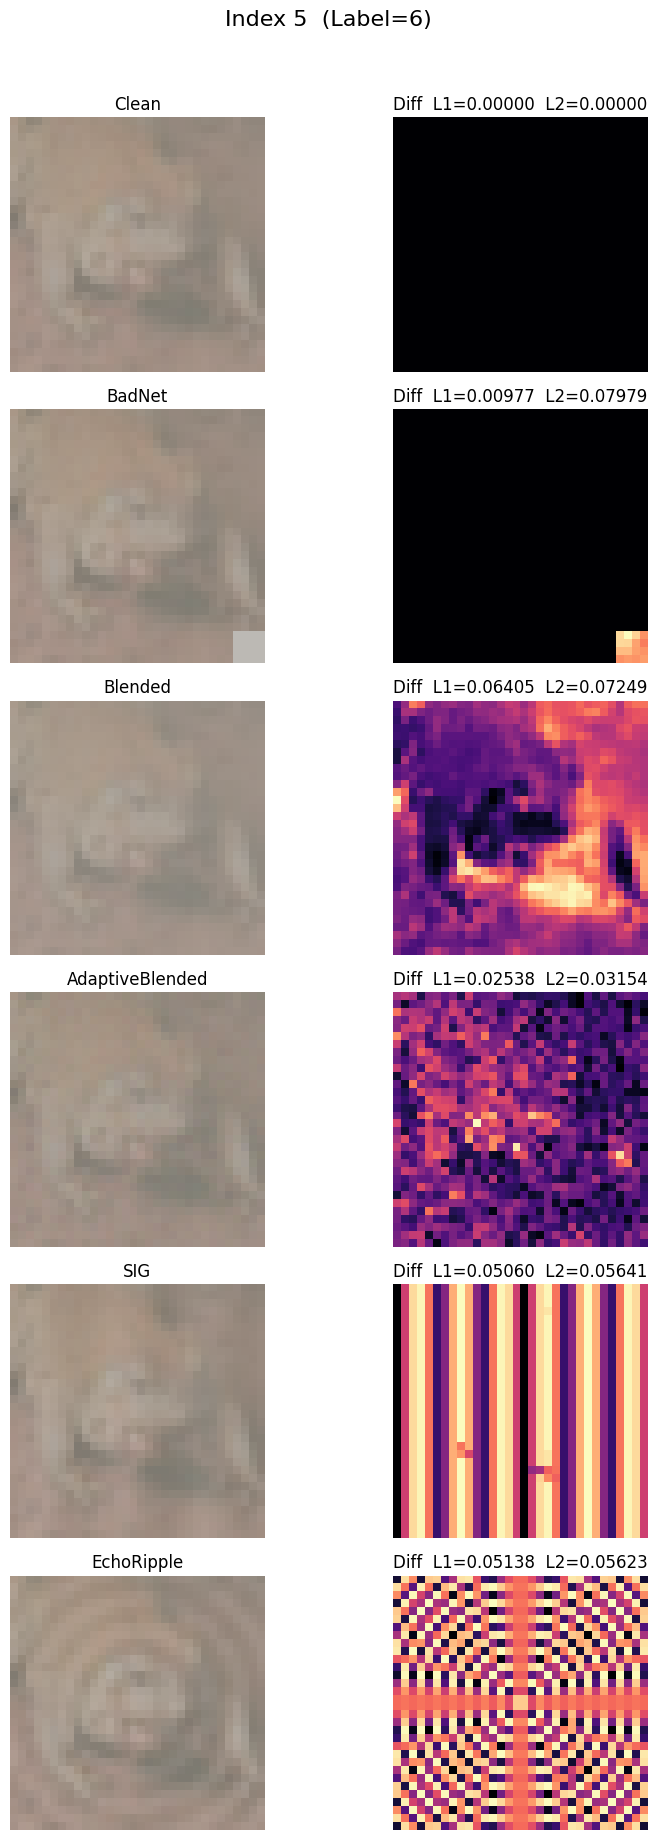


=== Summary for test index 10 ===
Clean            | L1=0.000000 | L2=0.000000
BadNet           | L1=0.008185 | L2=0.066448
Blended          | L1=0.033299 | L2=0.038631
AdaptiveBlended  | L1=0.036707 | L2=0.042506
SIG              | L1=0.050766 | L2=0.056569
EchoRipple       | L1=0.051505 | L2=0.056350


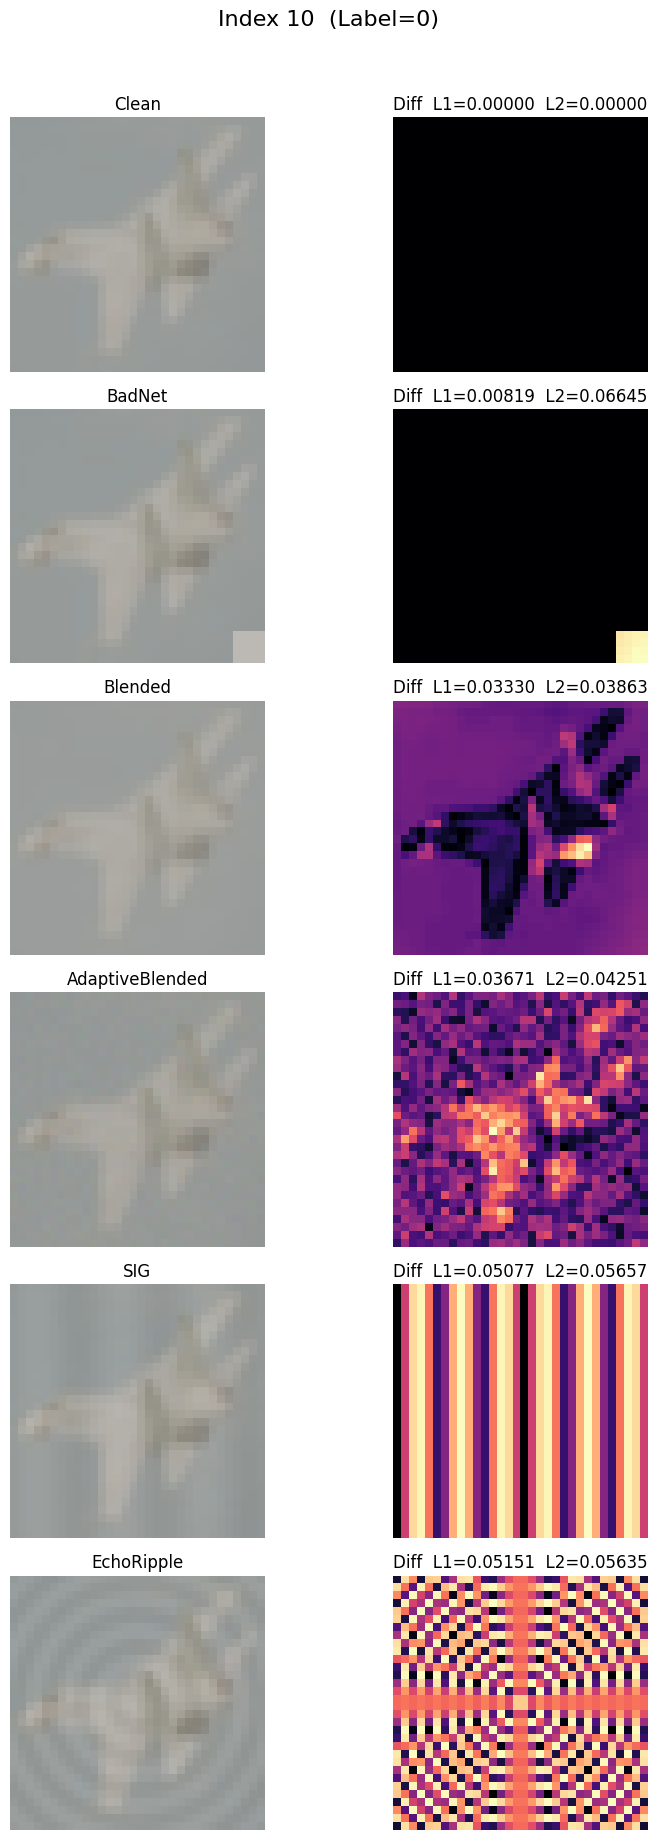


All images saved to: /content/backdoor_visuals


In [ ]:
# ============================
# Clean vs All 5 Attacks + Difference Maps
# ============================
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils

SAVE_DIR = "/content/backdoor_visuals"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------- pick which test images you want to visualize ----------
visual_indices = [0, 5, 10]      # change if needed

# -------- your existing attack functions (assumed already defined) ----------
attacks = {
    "Clean": None,
    "BadNet": badnet_trigger,
    "Blended": blended_trigger,
    "AdaptiveBlended": adaptive_blended_trigger,
    "SIG": sig_trigger,
    "EchoRipple": echoripple_trigger
}

# -------- convert normalized tensor -> numpy [0,1] --------
def to_np(img):
    img = to_01(img).clamp(0,1)     # your own to_01()
    img = img.cpu().numpy()
    return np.transpose(img, (1,2,0))    # C,H,W -> H,W,C

# -------- difference maps + scores --------
def compute_diff(clean01, atk01):
    diff = (clean01 - atk01).abs()
    l1 = diff.mean().item()
    l2 = torch.sqrt((diff**2).mean()).item()
    return diff, l1, l2

# -------- main loop --------
for idx in visual_indices:

    clean_norm, label = test_dataset[idx]
    clean01 = to_01(clean_norm).clamp(0,1)

    fig, axs = plt.subplots(len(attacks), 2, figsize=(9, 3*len(attacks)))
    fig.suptitle(f"Index {idx}  (Label={label})", fontsize=16, y=1.02)

    print(f"\n=== Summary for test index {idx} ===")

    for r, (name, trig) in enumerate(attacks.items()):

        # create attacked image
        if trig is None:
            atk01 = clean01.clone()
        else:
            atk01 = trig(clean01.clone()).clamp(0,1)

        # compute diff
        diff, l1, l2 = compute_diff(clean01, atk01)

        # convert for showing
        img_np = to_np(atk01 if name != "Clean" else clean01)
        diff_np = diff.mean(dim=0).cpu().numpy()

        # ---- show image ----
        axs[r,0].imshow(img_np)
        axs[r,0].axis("off")
        axs[r,0].set_title(f"{name}")

        # ---- show diff heatmap ----
        axs[r,1].imshow(diff_np, cmap="magma")
        axs[r,1].axis("off")
        axs[r,1].set_title(f"Diff  L1={l1:.5f}  L2={l2:.5f}")

        # ---- save outputs ----
        vutils.save_image((atk01 * std + mean).clamp(0,1),
                          f"{SAVE_DIR}/idx{idx}_{name}.png")

        diff_vis = (diff_np - diff_np.min()) / (diff_np.max() - diff_np.min() + 1e-8)
        plt.imsave(f"{SAVE_DIR}/idx{idx}_{name}_diff.png",
                   np.stack([diff_vis]*3, axis=2))

        print(f"{name:16s} | L1={l1:.6f} | L2={l2:.6f}")

    plt.tight_layout()
    plt.show()

print("\nAll images saved to:", SAVE_DIR)


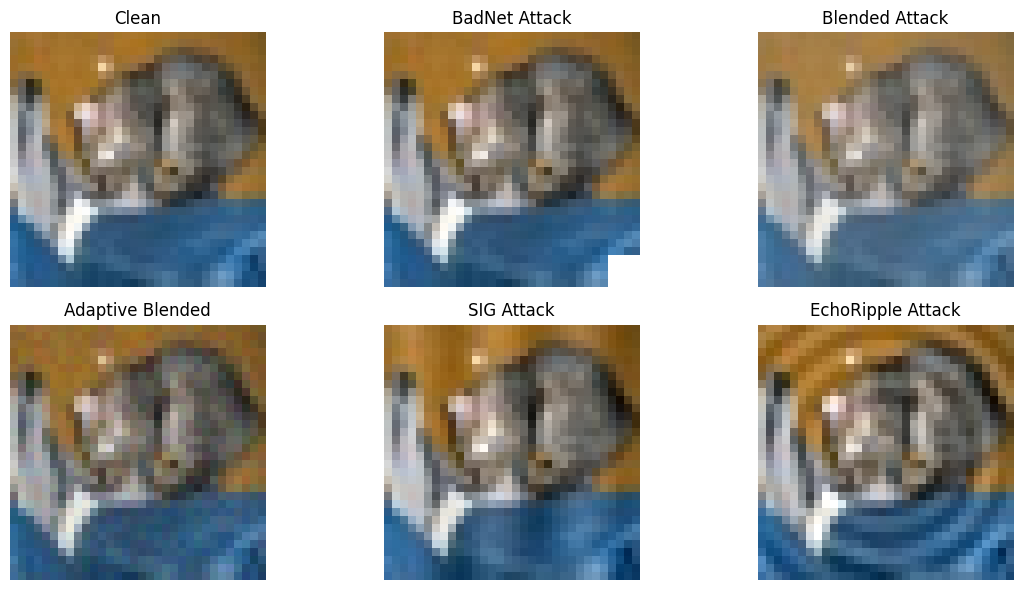

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ======================
# Load CIFAR-10
# ======================
transform = transforms.Compose([
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
image, label = testset[0]  # sample image

# ======================
# Helper to show images
# ======================
def show(img, title=""):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# ======================
# Apply 5 Attacks
# (Attack functions already exist in your notebook)
# ======================

clean_img = image

badnet_img = badnet_trigger(image.clone())
blended_img = blended_trigger(image.clone())
adaptive_img = adaptive_blended_trigger(image.clone())
sig_img = sig_trigger(image.clone())
echo_img = echoripple_trigger(image.clone())

# ======================
# Display all images
# ======================
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
show(clean_img, "Clean")

plt.subplot(2, 3, 2)
show(badnet_img, "BadNet Attack")

plt.subplot(2, 3, 3)
show(blended_img, "Blended Attack")

plt.subplot(2, 3, 4)
show(adaptive_img, "Adaptive Blended")

plt.subplot(2, 3, 5)
show(sig_img, "SIG Attack")

plt.subplot(2, 3, 6)
show(echo_img, "EchoRipple Attack")

plt.tight_layout()
plt.show()


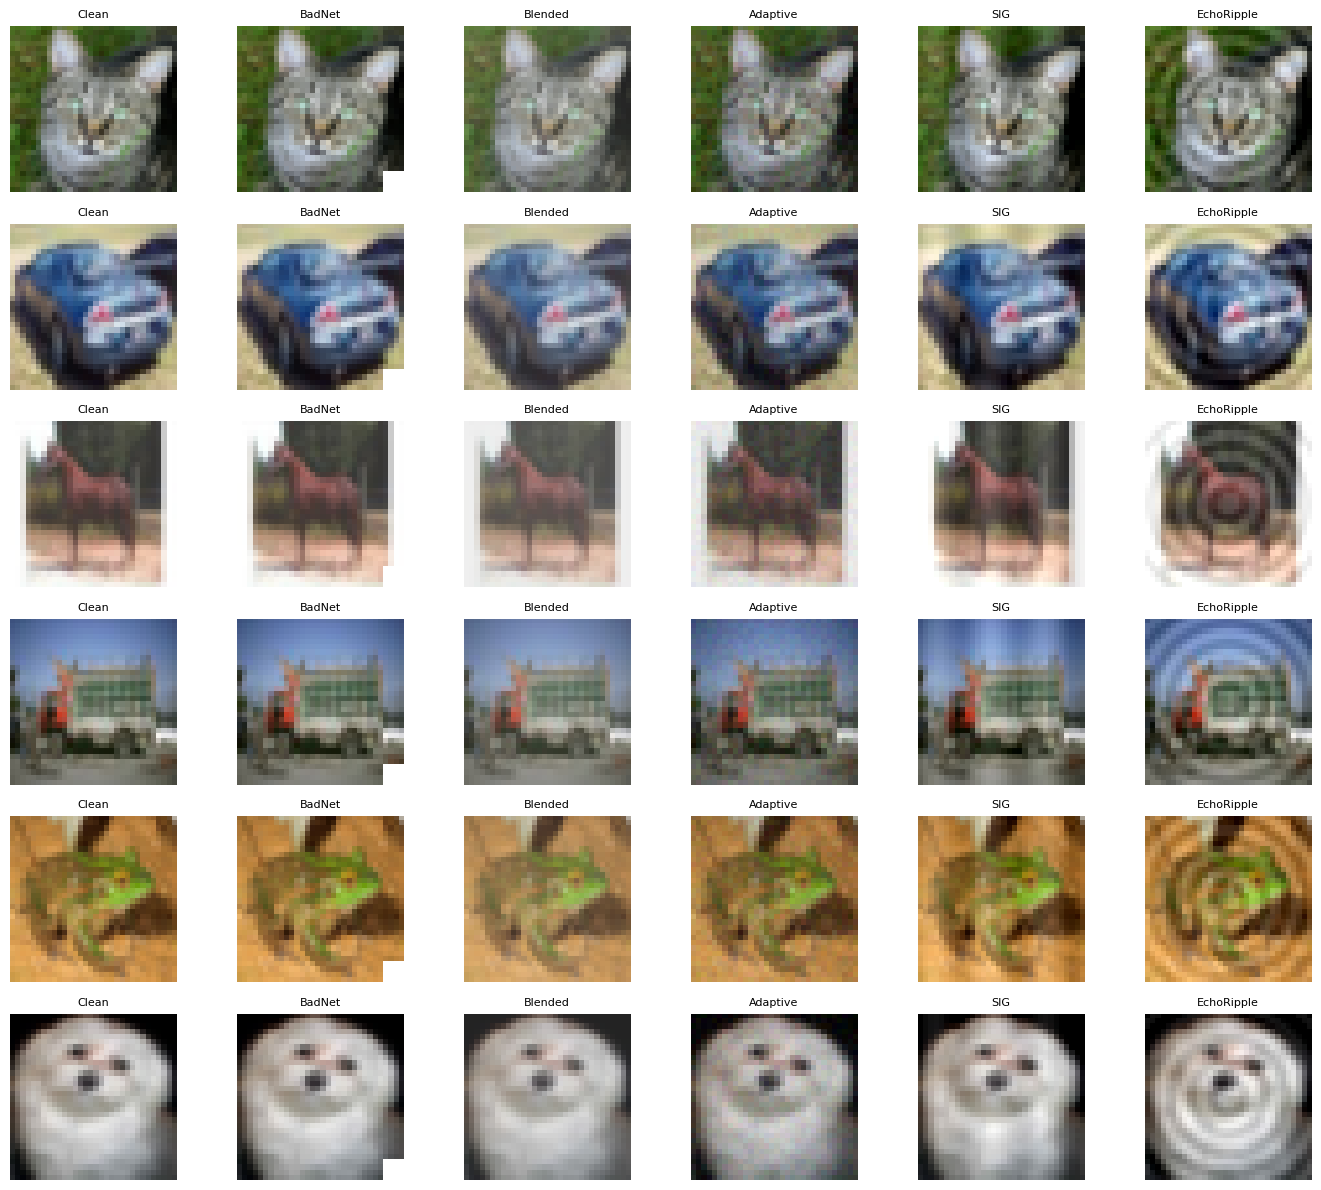

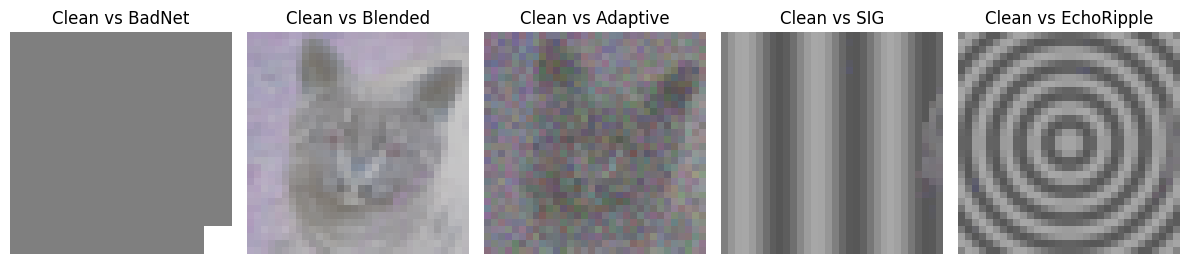

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# ======================================
# LOAD CIFAR-10
# ======================================
transform = transforms.ToTensor()
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# ======================================
# VISUALIZATION HELPER
# ======================================
def show_image(img, title=""):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.axis("off")

# ======================================
# GET RANDOM IMAGES FROM 6 DIFFERENT CLASSES
# ======================================
classes = list(range(10))
random.shuffle(classes)
selected_classes = classes[:6]         # choose 6 random classes

samples = []
for cls in selected_classes:
    idx = random.choice([i for i, (_, lab) in enumerate(testset) if lab == cls])
    samples.append(testset[idx])

# ======================================
# APPLY ALL 5 ATTACKS TO EACH IMAGE
# ======================================
all_outputs = []  # [(clean, badnet, blended, adaptive, sig, echo), ...]

for img, label in samples:
    clean = img
    bad = badnet_trigger(img.clone())
    blend = blended_trigger(img.clone())
    adap = adaptive_blended_trigger(img.clone())
    sig = sig_trigger(img.clone())
    echo = echoripple_trigger(img.clone())

    all_outputs.append((clean, bad, blend, adap, sig, echo))

# ======================================
# SHOW ALL IMAGES (Clean + 5 Attacks)
# ======================================
fig = plt.figure(figsize=(14, 12))
cols = 6
rows = len(all_outputs)

titles = ["Clean", "BadNet", "Blended", "Adaptive", "SIG", "EchoRipple"]

for r, imgs in enumerate(all_outputs):
    for c, img in enumerate(imgs):
        ax = fig.add_subplot(rows, cols, r*cols + c + 1)
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1,2,0)))
        ax.set_title(titles[c], fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

# ======================================
# COMPARISON MATRIX (CLEAN vs 5 ATTACKS)
# ======================================
fig2 = plt.figure(figsize=(12, 10))

for i, title in enumerate(titles[1:], 1):  # skip clean for grid row labels
    clean_img = all_outputs[0][0]          # use first clean image for comparison
    attacked_img = all_outputs[0][i]

    ax = fig2.add_subplot(1, 5, i)
    diff = (attacked_img - clean_img) * 2 + 0.5  # amplify differences for visibility
    npimg = diff.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)))
    ax.set_title(f"Clean vs {title}")
    ax.axis("off")

plt.tight_layout()
plt.show()


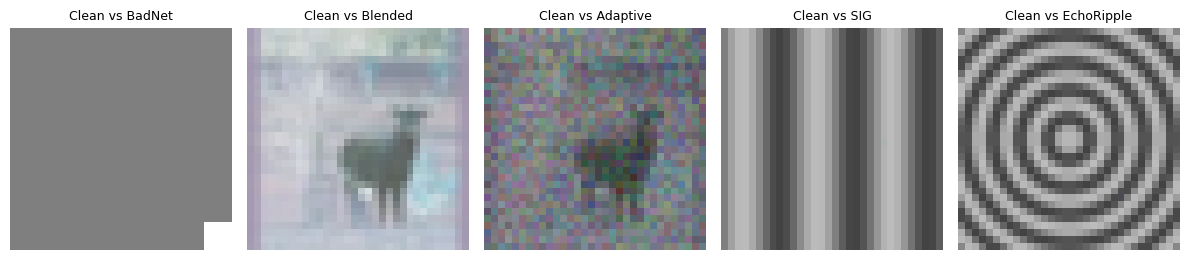

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# ==========================
# Load CIFAR-10
# ==========================
transform = transforms.ToTensor()
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# pick one random image
idx = random.randint(0, len(testset)-1)
clean_img, label = testset[idx]

# ==========================
# Apply 5 Attacks
# ==========================
bad = badnet_trigger(clean_img.clone())
blend = blended_trigger(clean_img.clone())
adap = adaptive_blended_trigger(clean_img.clone())
sig = sig_trigger(clean_img.clone())
echo = echoripple_trigger(clean_img.clone())

attacked_images = [bad, blend, adap, sig, echo]
titles = ["BadNet", "Blended", "Adaptive", "SIG", "EchoRipple"]

# ==========================
# Plot Comparison Matrix Only
# Clean vs Attacked Differences
# ==========================
plt.figure(figsize=(12, 6))

for i, (img, title) in enumerate(zip(attacked_images, titles)):
    # difference visualization
    diff = (img - clean_img) * 3 + 0.5   # amplify for visibility

    ax = plt.subplot(1, 5, i+1)
    npimg = diff.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)))
    ax.set_title(f"Clean vs {title}", fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import random

# ======================
# Load CIFAR-10
# ======================
transform = transforms.ToTensor()
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# pick one random CIFAR-10 sample
idx = random.randint(0, len(testset)-1)
clean_img, label = testset[idx]

# ======================
# Apply Attacks
# (your trigger functions)
# ======================
bad = badnet_trigger(clean_img.clone())
blend = blended_trigger(clean_img.clone())
adap = adaptive_blended_trigger(clean_img.clone())
sig = sig_trigger(clean_img.clone())
echo = echoripple_trigger(clean_img.clone())

attacks = {
    "BadNet": bad,
    "Blended": blend,
    "AdaptiveBlended": adap,
    "SIG": sig,
    "EchoRipple": echo
}

# ======================
# Produce Numeric Comparison Matrices
# ======================
comparison_matrices = {}

for name, attacked in attacks.items():
    # absolute pixel-wise difference
    diff = torch.abs(clean_img - attacked)

    # store numeric matrix
    comparison_matrices[name] = diff

# ======================
# Print Numeric Results
# ======================
for name, matrix in comparison_matrices.items():
    print("\n==============================")
    print(f"📌 NUMERIC COMPARISON MATRIX: Clean vs {name}")
    print("==============================")
    print(matrix)        # full pixel tensor (3 × 32 × 32)
    print("Matrix shape:", matrix.shape)



📌 NUMERIC COMPARISON MATRIX: Clean vs BadNet
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.6706, 0.6471, 0.7020],
         [0.0000, 0.0000, 0.0000,  ..., 0.6706, 0.6471, 0.6745],
         [0.0000, 0.0000, 0.0000,  ..., 0.6588, 0.6471, 0.6471]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.7490, 0.7490, 0.8235],
         [0.0000, 0.0000, 0.0000,  ..., 0.7490, 0.7412, 0.7843],
         [0.0000, 0.0000, 0.0000,  ..., 0.7333, 0.7294, 0.7412]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.

In [ ]:
import torch

# ============================
# Your Recorded Evaluation Data
# ============================

attacks = ["BadNet", "Blended", "AdaptiveBlended", "SIG", "EchoRipple"]

clean_acc = torch.tensor([0.6917, 0.6658, 0.6749, 0.6949, 0.6714])
asr        = torch.tensor([0.9644, 0.4374, 0.1788, 0.9570, 0.9914])

# ============================
# Build Comparison Matrix
# Shape = 5 attacks × 2 metrics
# ============================

comparison_matrix = torch.stack([clean_acc, asr], dim=1)

# ============================
# Print Comparison Matrix
# ============================

print("Attack Comparison Matrix (Clean Accuracy vs ASR):\n")
for i, attack in enumerate(attacks):
    print(f"{attack:17s}  CleanAcc = {comparison_matrix[i,0]:.4f}   ASR = {comparison_matrix[i,1]:.4f}")

print("\nRaw Numeric Matrix Tensor:\n")
print(comparison_matrix)


Attack Comparison Matrix (Clean Accuracy vs ASR):

BadNet             CleanAcc = 0.6917   ASR = 0.9644
Blended            CleanAcc = 0.6658   ASR = 0.4374
AdaptiveBlended    CleanAcc = 0.6749   ASR = 0.1788
SIG                CleanAcc = 0.6949   ASR = 0.9570
EchoRipple         CleanAcc = 0.6714   ASR = 0.9914

Raw Numeric Matrix Tensor:

tensor([[0.6917, 0.9644],
        [0.6658, 0.4374],
        [0.6749, 0.1788],
        [0.6949, 0.9570],
        [0.6714, 0.9914]])


                 CleanAcc    ASR  Stealth  Robust  Complexity  Cost  Overall
Attack                                                                      
BadNet              69.17  96.44        2       5           1     1    83.33
Blended             66.58  43.74        4       4           3     2    58.22
AdaptiveBlended     67.49  17.88        5       3           4     3    44.65
SIG                 69.49  95.70        2       4           1     1    81.13
EchoRipple          67.14  99.14        1       5           2     1    80.05


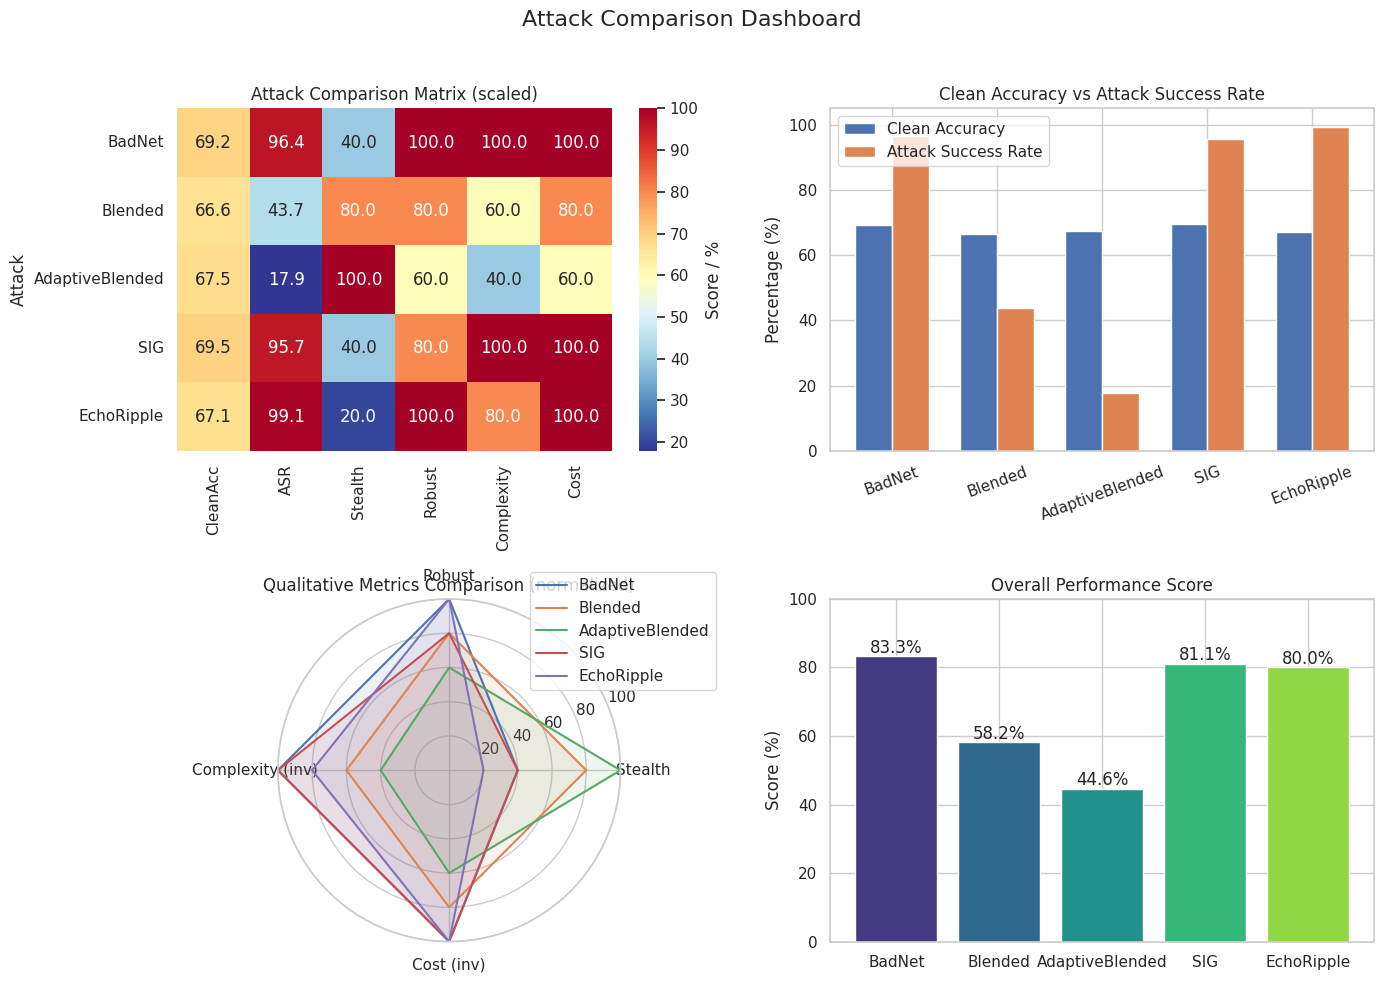

In [ ]:
# Required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Data: replace values if you want ----------
attacks = ["BadNet", "Blended", "AdaptiveBlended", "SIG", "EchoRipple"]

# Percent values (0-100)
clean_acc = {
    "BadNet": 69.17,
    "Blended": 66.58,
    "AdaptiveBlended": 67.49,
    "SIG": 69.49,
    "EchoRipple": 67.14
}
asr = {
    "BadNet": 96.44,
    "Blended": 43.74,
    "AdaptiveBlended": 17.88,
    "SIG": 95.70,
    "EchoRipple": 99.14
}

# Qualitative metrics (1-5)
scores = {
    "BadNet":          {"Stealth": 2, "Robust": 5, "Complexity": 1, "Cost": 1},
    "Blended":         {"Stealth": 4, "Robust": 4, "Complexity": 3, "Cost": 2},
    "AdaptiveBlended": {"Stealth": 5, "Robust": 3, "Complexity": 4, "Cost": 3},
    "SIG":             {"Stealth": 2, "Robust": 4, "Complexity": 1, "Cost": 1},
    "EchoRipple":      {"Stealth": 1, "Robust": 5, "Complexity": 2, "Cost": 1},
}

# ---------- Compute Overall Score (weights adjustable) ----------
# We'll use a weighted combination of ASR, CleanAcc and normalized qualitative metrics
# We normalize qualitative metrics to 0-100 scale: 1 -> 0, 5 -> 100 (linear)
def normalize_q(x):
    return (x - 1) / 4 * 100

overall_rows = []
for a in attacks:
    s = scores[a]
    stealth_pct = normalize_q(s["Stealth"])
    robust_pct  = normalize_q(s["Robust"])
    complexity_inv_pct = normalize_q(6 - s["Complexity"])  # lower complexity -> higher score
    cost_inv_pct = normalize_q(6 - s["Cost"])              # lower cost -> higher score

    # weights (sum=1.0)
    w_asr = 0.40
    w_clean = 0.30
    w_stealth = 0.08
    w_robust = 0.08
    w_complex = 0.07
    w_cost = 0.07

    overall = (
        asr[a] * w_asr +
        clean_acc[a] * w_clean +
        stealth_pct * w_stealth +
        robust_pct * w_robust +
        complexity_inv_pct * w_complex +
        cost_inv_pct * w_cost
    )

    overall_rows.append({
        "Attack": a,
        "CleanAcc": clean_acc[a],
        "ASR": asr[a],
        "Stealth": s["Stealth"],
        "Robust": s["Robust"],
        "Complexity": s["Complexity"],
        "Cost": s["Cost"],
        "Overall": round(overall, 2)
    })

df = pd.DataFrame(overall_rows).set_index("Attack")
print(df)

# ---------- Plotting: 2x2 figure ----------
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14,10))

# 1) Heatmap: comparison matrix (CleanAcc, ASR, Stealth, Robust, Complexity, Cost)
ax1 = fig.add_subplot(2,2,1)
cmp_df = df[["CleanAcc","ASR","Stealth","Robust","Complexity","Cost"]]
# scale qualitative columns to similar range for visual consistency
cmp_plot = cmp_df.copy()
cmp_plot["Stealth"] = cmp_plot["Stealth"] / 5.0 * 100
cmp_plot["Robust"]  = cmp_plot["Robust"]  / 5.0 * 100
cmp_plot["Complexity"] = (6 - cmp_plot["Complexity"]) / 5.0 * 100  # invert complexity for 'good' in heatmap
cmp_plot["Cost"] = (6 - cmp_plot["Cost"]) / 5.0 * 100
sns.heatmap(cmp_plot, annot=True, fmt=".1f", cmap="RdYlBu_r", cbar_kws={'label':'Score / %'}, ax=ax1)
ax1.set_title("Attack Comparison Matrix (scaled)")

# 2) Bar chart: Clean Accuracy vs ASR
ax2 = fig.add_subplot(2,2,2)
x = np.arange(len(attacks))
width = 0.35
ax2.bar(x - width/2, [df.loc[a,"CleanAcc"] for a in attacks], width, label="Clean Accuracy")
ax2.bar(x + width/2, [df.loc[a,"ASR"] for a in attacks], width, label="Attack Success Rate")
ax2.set_xticks(x)
ax2.set_xticklabels(attacks, rotation=20)
ax2.set_ylim(0,105)
ax2.set_ylabel("Percentage (%)")
ax2.set_title("Clean Accuracy vs Attack Success Rate")
ax2.legend()

# 3) Radar chart: qualitative metrics comparison (Stealth, Robust, Complexity(inverted), Cost(inverted), Robust)
# we will plot Stealth, Robustness, Complexity_inverted, Cost_inverted
ax3 = fig.add_subplot(2,2,3, polar=True)
labels = ["Stealth","Robust","Complexity (inv)","Cost (inv)"]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
# plotting each attack
for a in attacks:
    vals = [
        df.loc[a,"Stealth"]/5.0 * 100,
        df.loc[a,"Robust"]/5.0 * 100,
        (6 - df.loc[a,"Complexity"]) /5.0 * 100,
        (6 - df.loc[a,"Cost"]) /5.0 * 100
    ]
    vals += vals[:1]
    ax3.plot(angles, vals, label=a)
    ax3.fill(angles, vals, alpha=0.1)
ax3.set_thetagrids(np.degrees(angles[:-1]), labels)
ax3.set_ylim(0,100)
ax3.set_title("Qualitative Metrics Comparison (normalized)")
ax3.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

# 4) Overall performance bar chart
ax4 = fig.add_subplot(2,2,4)
ax4.bar(attacks, df["Overall"], color=sns.color_palette("viridis", len(attacks)))
ax4.set_ylim(0,100)
for i, v in enumerate(df["Overall"]):
    ax4.text(i, v+1, f"{v:.1f}%", ha='center')
ax4.set_title("Overall Performance Score")
ax4.set_ylabel("Score (%)")

plt.suptitle("Attack Comparison Dashboard", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])

# Save figure (optional)
plt.savefig("attack_comparison_dashboard.png", dpi=200)
plt.show()
